# Technical Assignment: Combining two dishes

Ángel Martínez-Tenor. September 25, 2018

Goal: Get samples that could potentially be considered as a combination of Sandwich and Sushi

Input: 2 separated folders with 402 pictures of sandwiches and 402 pictures of sushi

Methodology: Build, train and validate several custom and pretrained convolutional networks. Select the best model (highest validation accuracy) and display potential combinations: those misclassified or with output (sigmoid)  ∈  (0.45, 0.55).

Only the best model obtained is shown here: MobileNet with input size (224,224) pretrained with imagenet with a small fully connected classified trained and tuned for the input dataset.


This implementation is largely influenced and reuses code from the following sources:

- [Francois Chollet: 'Building powerful image classification models using very little data'](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html)  (main guide)

- [Bharat Kunwar: 'Sushi or Sandwich classifier'](https://github.com/brtknr/SushiSandwichClassifier/blob/master/sushi-or-sandwich-keras.ipynb) (base classifier)

- [Angel Martínez-Tenor: 'Data science projects with Keras'](https://github.com/angelmtenor/data-science-keras) (setup, structure, and helper functions)





In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import keras
import helper  # custom library for this assigment

helper.info_gpu()
sns.set_palette("Reds")
helper.reproducible(seed=0)  # setup reproducible results from run to run using Keras

%matplotlib inline

Using TensorFlow backend.


device:GPU:0
Keras		v2.2.2
TensorFlow	v1.10.0


## 0. Load the Data

In [2]:
import zipfile

cloud_path = 'http://research.us-east-1.s3.amazonaws.com/public/sushi_or_sandwich_photos.zip'
data_file = 'sushi_or_sandwich_photos.zip'
data_dir = "sushi_or_sandwich"

# Download the pictures
if not os.path.isfile(data_file):
    print('Downloading data ...')
    os.system('wget ' + cloud_path)
    print('Downloading data ... OK\n')

# Extract the pictures
if not os.path.isdir(data_dir):
    print('Extracting data ...')
    zip_ref = zipfile.ZipFile(data_file, 'r')
    zip_ref.extractall('./')
    zip_ref.close()
    print('Extracting data ... OK\n')


Extracting data ...
Extracting data ... OK



## 1. Explore and Process the Data

### Visualize the data

pictures:
sandwich   	402
sushi   	402


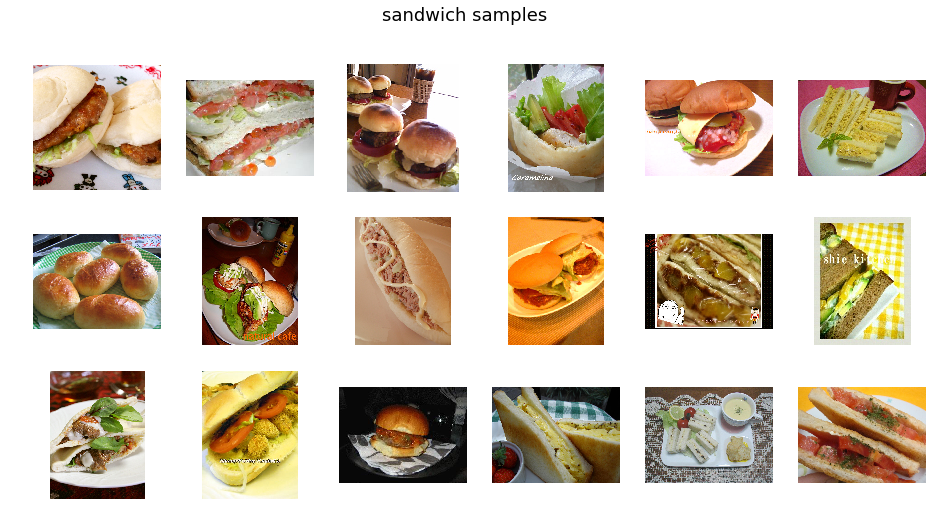

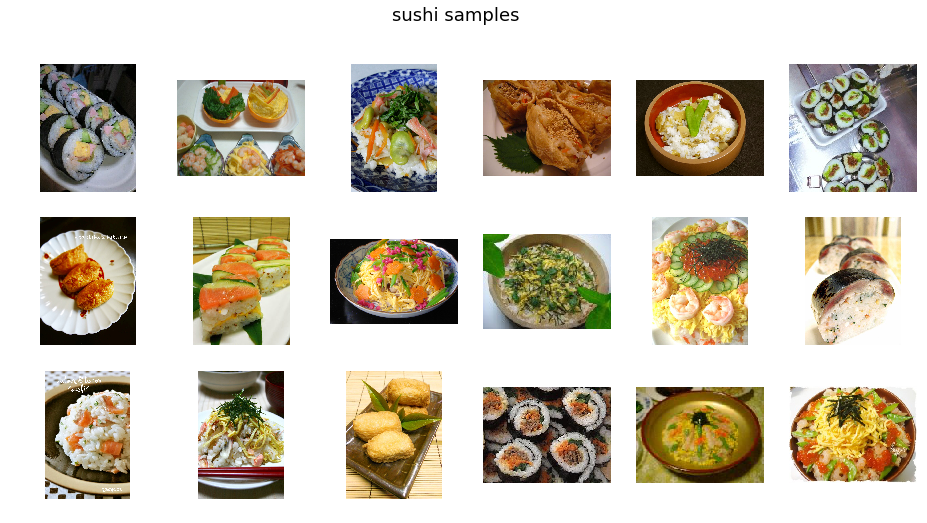

In [3]:
from PIL import Image
from pylab import gcf


def load_samples(path, size):
    """ load and return an array of images """
    imagesList = os.listdir(path)
    samples = []
    for image in imagesList[:size]:
        img = Image.open(os.path.join(path, image))
        samples.append(img)
    return samples


for c in ('sandwich', 'sushi'):
    path = os.path.join(data_dir, c)
    imgs = load_samples(path, 18)

    plt.figure(figsize=(16, 8))
    gcf().suptitle(c + " samples", fontsize=18)

    for i, img in enumerate(imgs):
        # you can show every image
        plt.subplot(3, 6, i + 1)
        plt.imshow(img)
        plt.axis('off')

# Print the number of pictures
print("pictures:")
for c in ('sandwich', 'sushi'):
    path = os.path.join(data_dir, c)
    print("{}   \t{}".format(
        c, len([name for name in os.listdir(path) if os.path.isfile(os.path.join(path, name))])))

###  Split the data into training and validation sets (not enough data for 3 partitions)

In [4]:
import shutil
import glob

val_size = 0.3 # size the of validation set
train_dir = "train"
val_dir = "validation"

# remove existing sets
for d in (train_dir, val_dir):
    if os.path.isdir(d):
        shutil.rmtree(d)
        print('old ' + d + ' directory deleted')
    # create empty directories
    for c in ('sandwich', 'sushi'):
        os.makedirs(os.path.join(d, c))
    print('empty ' + d + ' directory created')

# Create training and validation sets
for c in ('sandwich', 'sushi'):
    files = glob.glob('{}/{}/*.jpg'.format(data_dir, c))
    indices = np.random.permutation(len(files))
    train_val_split = int(len(files) * (val_size))
    for i, ix in enumerate(indices):
        src = files[ix]
        dest = '{}/{}/{}'.format(val_dir if i < train_val_split else train_dir, c,
                                 files[ix].split('/')[-1])
        shutil.copyfile(src, dest)

# Print the number of pictures in each set
print("\npictures:")
for d in (train_dir, val_dir):
    for c in ('sandwich', 'sushi'):
        path = os.path.join(d, c)
        print("{} {}  {}".format(
            d, c, len([n for n in os.listdir(path) if os.path.isfile(os.path.join(path, n))])))

empty train directory created
empty validation directory created

pictures:
train sandwich  282
train sushi  282
validation sandwich  120
validation sushi  120


### Create image generators with data augmentation

In [5]:
img_width, img_height = 224, 224
batch_size = 32

from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.4,  # high change of persperctive in this pictures
    zoom_range=0.2,
    horizontal_flip=True)

val_datagen = ImageDataGenerator(rescale=1 / 255)

print('Image generators:')

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode="binary",
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode="binary",
)

Image generators:
Found 564 images belonging to 2 classes.
Found 240 images belonging to 2 classes.


## 2. Build and train the Neural Network model

### Load a well-known model pretrained on Imagenet dataset (only convolutional layers)

In [6]:
model_bottleneck = keras.applications.MobileNet(
    weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

for layer in model_bottleneck.layers:
    layer.trainable = False

### Get bottleneck features

In [7]:
import h5py

train_bottleneck_generator = train_datagen.flow_from_directory(
    train_dir,
    color_mode='rgb',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode=None,
    shuffle=False,
)

val_bottleneck_generator = val_datagen.flow_from_directory(
    val_dir,
    color_mode='rgb',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode=None,
    shuffle=False,
)

train_bottleneck = model_bottleneck.predict_generator(train_bottleneck_generator, verbose=1)
val_bottleneck = model_bottleneck.predict_generator(val_bottleneck_generator, verbose=1)
train_labels = train_generator.classes
val_labels = val_generator.classes

Found 564 images belonging to 2 classes.
Found 240 images belonging to 2 classes.
8/8 [==============================] - 4s 490ms/step


### Biuld a final fully connected classifier

In [8]:
model = None

from keras.models import Sequential, Model
from keras.layers import Dropout, Flatten, Dense, MaxPooling2D, Conv2D, InputLayer, Activation
from keras.callbacks import ModelCheckpoint, EarlyStopping


def build_top_nn(summary=False):

    w = keras.initializers.TruncatedNormal(mean=0.0, stddev=0.0001, seed=None)
    opt = keras.optimizers.Adamax(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0)

    model_top = Sequential()
    model_top.add(Flatten(input_shape=train_bottleneck.shape[1:]))
    model_top.add(Dense(16, kernel_initializer=w, bias_initializer='zeros'))
    model_top.add(Activation('relu'))
    model_top.add(Dropout(0.5))
    model_top.add(Dense(1, kernel_initializer=w, bias_initializer='zeros'))
    model_top.add(Activation('sigmoid'))

    if summary:
        model_top.summary()

    model_top.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

    return model_top


model_top = build_top_nn(summary=True)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 50176)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                802832    
_________________________________________________________________
activation_1 (Activation)    (None, 16)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
_________________________________________________________________
activation_2 (Activation)    (None, 1)                 0         
Total params: 802,849
Trainable params: 802,849
Non-trainable params: 0
_________________________________________________________________


### Train the Classifier with the bottleneck features

Training ....
time: 	 9.5 s


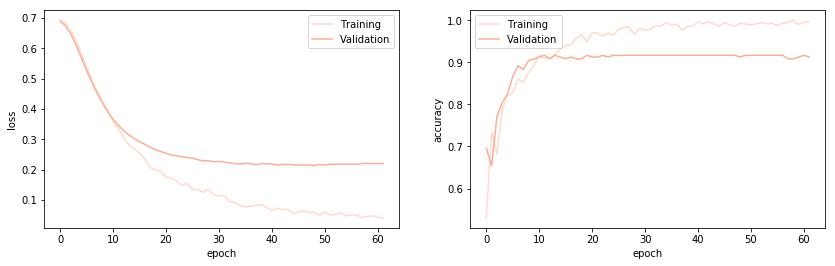


Training loss:  	0.0409
Validation loss: 	0.2206

Training accuracy: 	0.996
Validation accuracy:	0.912

Best model. Validation accuracy: 	 0.917


In [9]:
from time import time

# tuned hyperparameters
# batch_size = batch size for generators (above)
patience = 50
nb_epoch = 500


def train_nn(model, show=True):

    checkpoint = ModelCheckpoint(
        "checkpoint-top.h5",
        monitor='val_acc',
        verbose=0,
        save_best_only=True,
        save_weights_only=False,
        mode='auto',
        period=1)

    early = EarlyStopping(
        monitor='val_acc', min_delta=0, patience=patience, verbose=0, mode='auto')

    if show:
        print('Training ....')
        t0 = time()

    history = model_top.fit(
        train_bottleneck,
        train_labels,
        epochs=nb_epoch,
        batch_size=batch_size,
        verbose=0,
        validation_data=(val_bottleneck, val_labels),
        callbacks=[checkpoint, early])

    if show:
        print("time: \t {:.1f} s".format(time() - t0))
        helper.show_training(history)


model_top = None
model_top = build_top_nn(summary=False)
train_nn(model_top)

# restore best model found (callback-checkpoint)
model_top = None
model_top = keras.models.load_model("checkpoint-top.h5")

acc = model_top.evaluate(val_bottleneck, val_labels, verbose=0)[1]
print('\nBest model. Validation accuracy: \t {:.3f}'.format(acc))

## Build the full model (pretrained bottleneck + custom classifier)


In [10]:
# Stack Layers using Keras's fucntional approach:
full_model = Model(inputs=model_bottleneck.input, outputs=model_top(model_bottleneck.output))
full_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

## 3. Make Predictions and get Results

### Show and save potential dishes: pictures misclassified or with output (sigmoid) $\in$ (0.45, 0.55). Only the validation set is used here to avoid trained samples

Ideas for combining Sandwich and Sushi:
33 files saves in '/output'


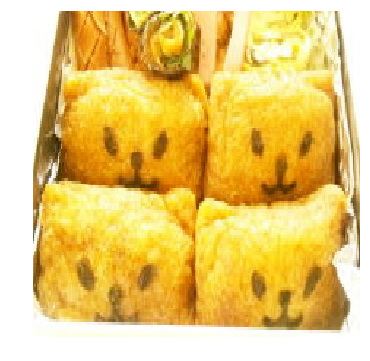

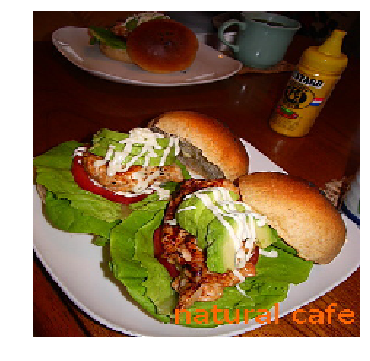

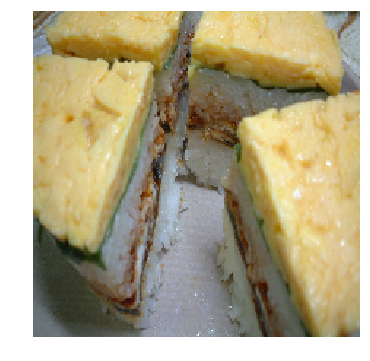

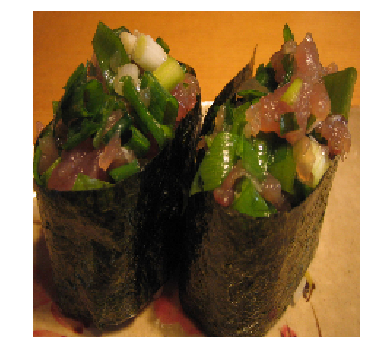

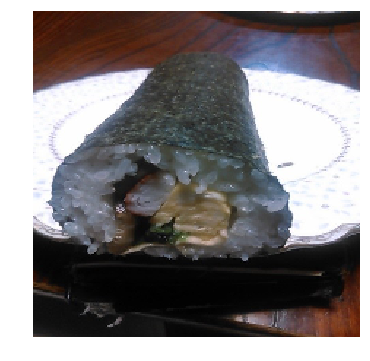

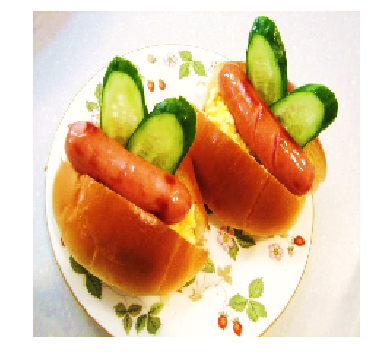

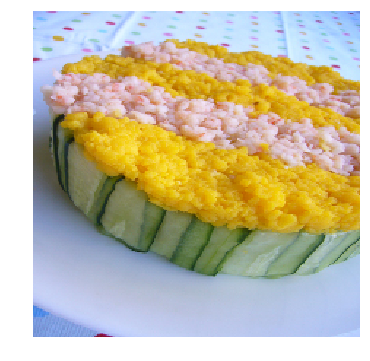

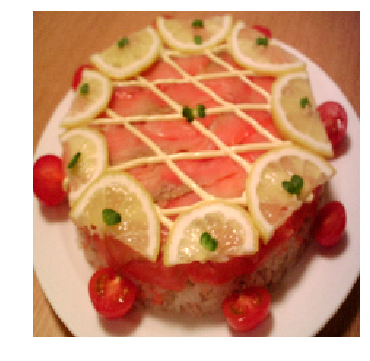

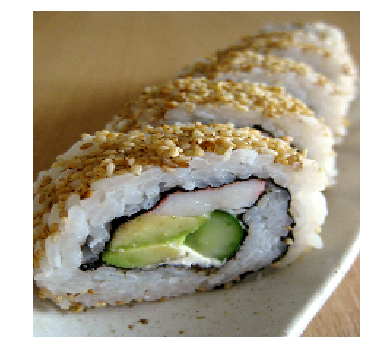

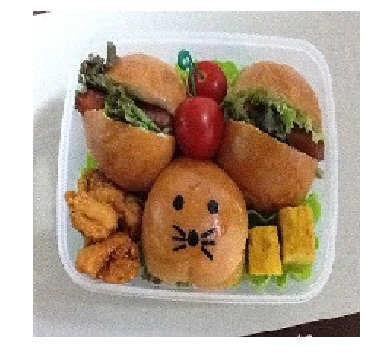

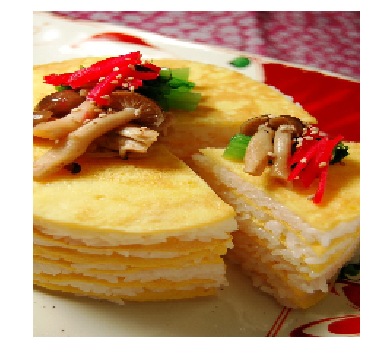

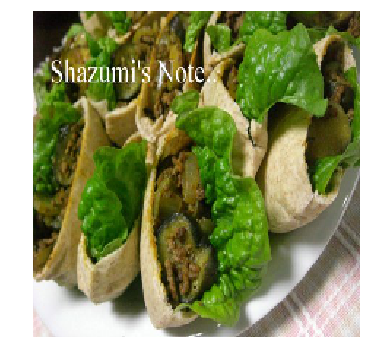

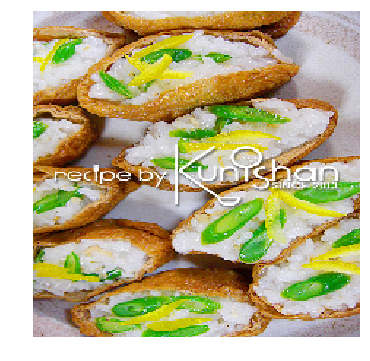

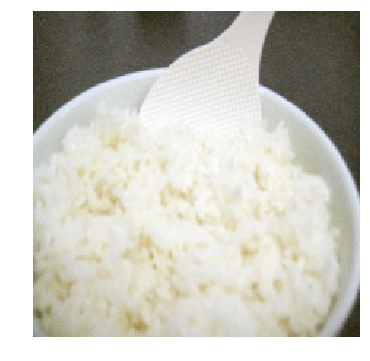

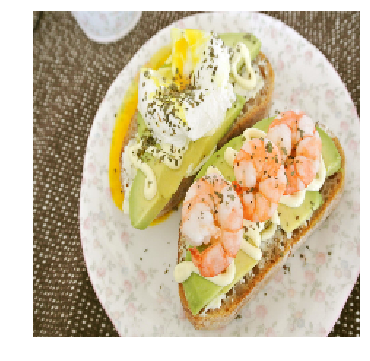

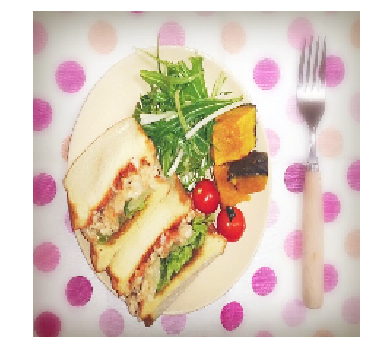

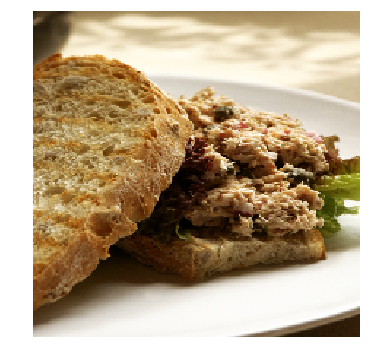

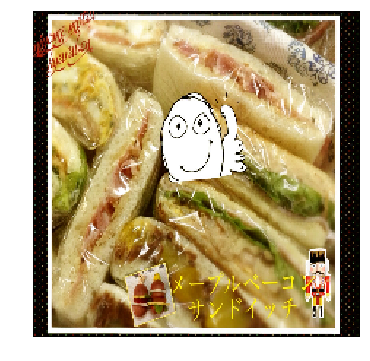

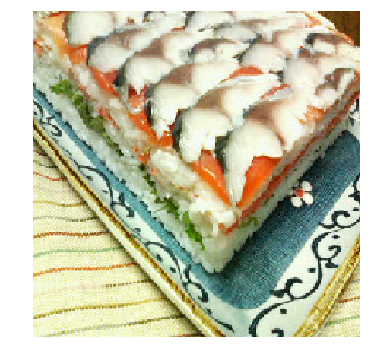

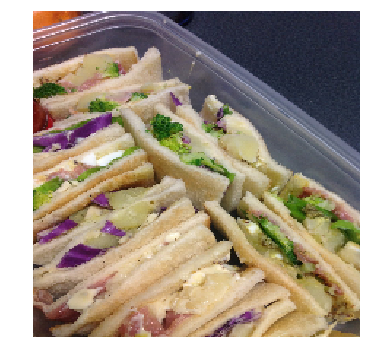

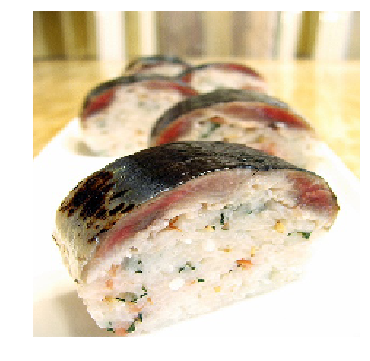

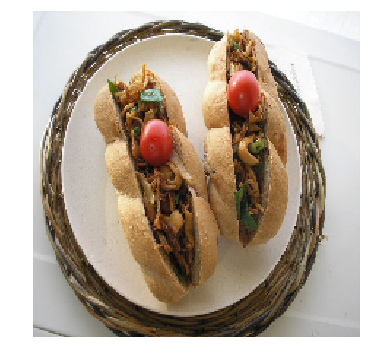

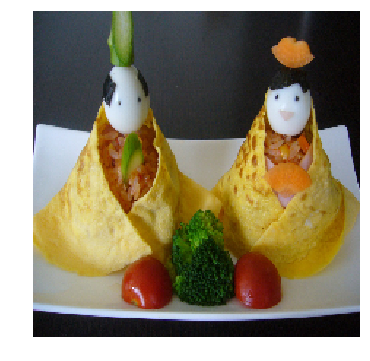

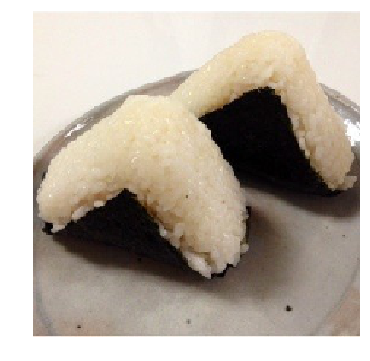

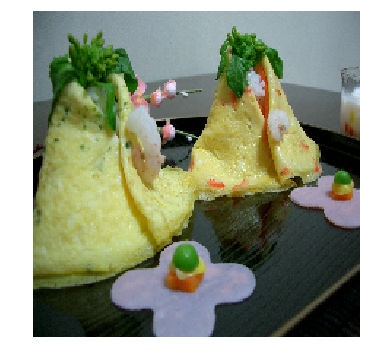

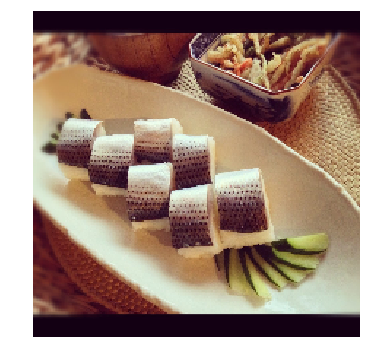

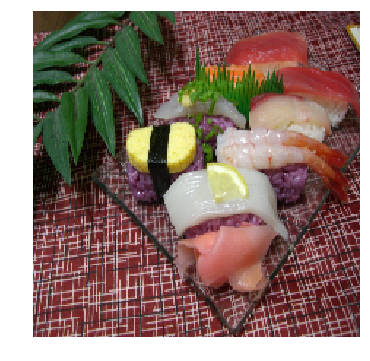

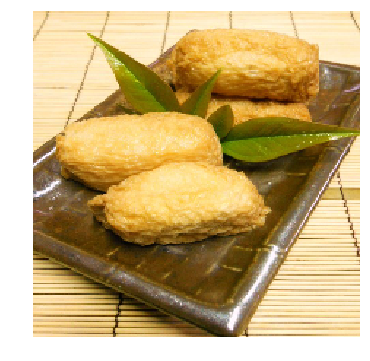

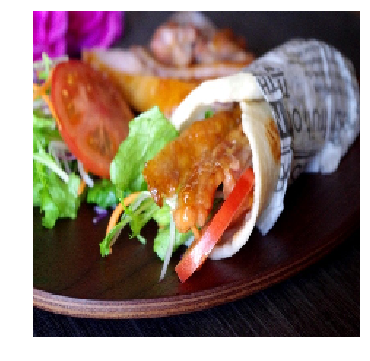

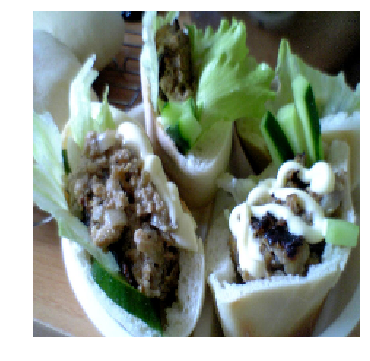

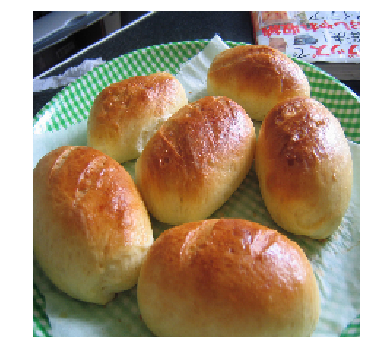

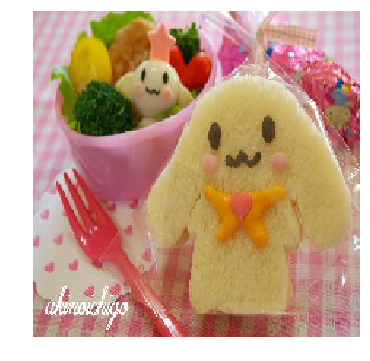

In [11]:
plt.rcParams.update({'figure.max_open_warning': 0})

output_dir = "output"

if os.path.isdir(output_dir):
    shutil.rmtree(output_dir)

os.makedirs(output_dir)

print("Potetntial combination of Sandwich and Sushi:")

n = 0
for i in range(len(val_generator)):
    images, labels = val_generator[i]
    predictions = full_model.predict(images)

    for im, l, p in zip(images, labels, predictions.flatten()):
        #if (p > 0.45 and p < 0.55):
        if (p > 0.45 and p < 0.55) or (l < 0.5 and p > 0.5) or (l > 0.5 and p < 0.5):
            n = n + 1
            plt.figure(figsize=(6, 6))
            plt.imshow(im)
            plt.axis('off')
            plt.savefig("{}/{}.jpg".format(output_dir, n))
print("{} files saves in '/{}'".format(n, output_dir))
plt.close()

In [12]:
# original_train_datagen = ImageDataGenerator(rescale=1./255)

# original_train_generator = original_train_datagen.flow_from_directory(
#     train_dir,
#     target_size=(img_height, img_width),
#     batch_size=batch_size,
#     class_mode="binary",
# )

# print("\nMixed Predictions from the training set:")

# for i in range(len(original_train_generator)):
#     images, labels = original_train_generator[i]
#     predictions = full_model.predict(images)

#     for ix, (im, l, p) in enumerate(zip(images, labels, predictions.flatten())):
#         if (p > 0.45 and p < 0.55) or (l<0.5 and p>0.5) or (l>0.5 and p<0.5):
#             plt.figure(figsize=(6, 6))
#             plt.imshow(im)
#             plt.axis('off')